# Case study: churn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, make_scorer, confusion_matrix
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Loading scrubbed data

In [3]:
df = pd.read_csv('data/scrubbed.csv')

In [4]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,city_Astapor,city_Winterfell,phone_iPhone
0,6.94,5.0,5.0,1.00,0.0,0,False,100.0,True,1,0,0
1,8.06,5.0,5.0,1.00,0.0,2,True,0.0,True,1,0,0
2,21.50,4.0,4.9,1.00,0.0,1,True,100.0,True,0,1,1
3,9.46,5.0,4.9,2.75,100.0,1,False,100.0,True,0,1,0
4,13.77,5.0,4.9,1.00,0.0,0,False,100.0,True,0,1,1


In [5]:
x = df.drop('churn',axis=1)
y = df.churn


# x = df[['trips_in_first_30_days','avg_dist','avg_surge']]
# y = df.churn

In [6]:
x.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,city_Astapor,city_Winterfell,phone_iPhone
0,6.94,5.0,5.0,1.00,0.0,0,False,100.0,1,0,0
1,8.06,5.0,5.0,1.00,0.0,2,True,0.0,1,0,0
2,21.50,4.0,4.9,1.00,0.0,1,True,100.0,0,1,1
3,9.46,5.0,4.9,2.75,100.0,1,False,100.0,0,1,0
4,13.77,5.0,4.9,1.00,0.0,0,False,100.0,0,1,1


### Setting up data with simple train/test split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Let's try Logistic regression

In [24]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
lr.score(x_test,y_test)

0.716125

In [36]:
AUC = roc_auc_score(y_test, lr.predict_proba(x_test)[:,1])
AUC

0.7610771503616762

In [37]:
roc_auc_score(y_test, lr.predict(x_test))

0.6712501186710838

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(x_test)[:,1])

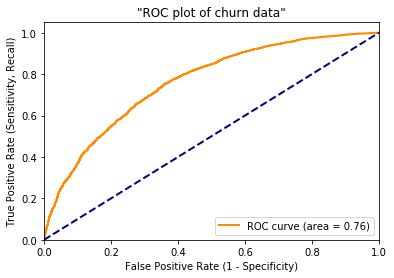

In [31]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title('"ROC plot of churn data"')
plt.legend(loc="lower right")

In [39]:
pd.crosstab(y_test, lr.predict(x_test))

col_0,False,True
churn,,
False,1475,1530
True,741,4254


In [40]:
def plot_confusion_matrix(model, X_test, y_true):
    '''Code from sklearn example.'''
    cm = confusion_matrix(y_true, model.predict(X_test))
    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[1475 1530]
 [ 741 4254]]


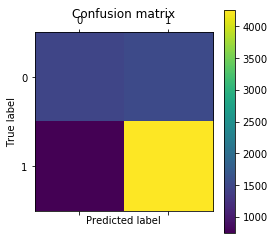

In [42]:
plot_confusion_matrix(lr, x_test, y_test)

### Next model: Gradient Boosting

As the model is non-linear, we may be tempted to use decision trees. But, it always makes sense to use an ensemble model to get best performance.

In [43]:
gb = GradientBoostingClassifier()
#params = {'learning_rate': np.logspace(-3,0,10), 'n_estimators': np.floor(np.logspace(0,2,10)), 'max_depth': np.arange(1,10,2)}
#clf = GridSearchCV(gb, params)
gb.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [45]:
gb.score(x_test,y_test)

0.778375

In [44]:
AUC = roc_auc_score(y_test, gb.predict_proba(x_test)[:,1])
AUC

0.8484608402079283

In [46]:
roc_auc_score(y_test, lr.predict(x_test))

0.6712501186710838

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(x_test)[:,1])

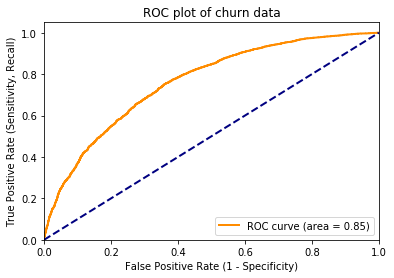

In [48]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title('ROC plot of churn data')
plt.legend(loc="lower right")

In [15]:
gb.feature_importances_

array([0.11737198, 0.08013821, 0.04782575, 0.03558268, 0.12785616,
       0.1176804 , 0.05987916, 0.16145256, 0.07042315, 0.11850285,
       0.0632871 ])

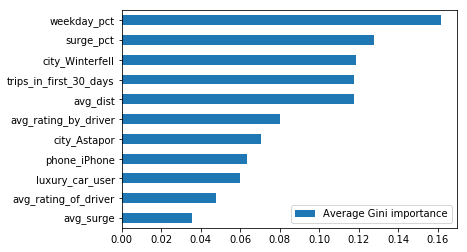

In [16]:
feat_scores = pd.DataFrame({'Average Gini importance' : gb.feature_importances_},
                           index=x.columns)
feat_scores = feat_scores.sort_values(by='Average Gini importance')
feat_scores.plot(kind='barh');

In [50]:
pd.crosstab(y_test, gb.predict(x_test))

col_0,False,True
churn,,
False,1970,1035
True,738,4257


[[1970 1035]
 [ 738 4257]]


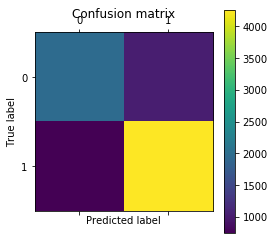

In [51]:
plot_confusion_matrix(gb, x_test, y_test)

This is better

## Refine model using Grid Search

In [53]:
gb = GradientBoostingClassifier()

params = {
    'learning_rate': [0.05, 0.7,0.1, 1.2], 
    'max_depth': [4,5],
    'n_estimators': [50,100,200,400,800], 
    }

# # Best settings
# params = {
#     'learning_rate': [0.05], 
#     'max_depth': [4],
#     'n_estimators': [400], 
#     }



params = {
    'learning_rate': [0.75, 0.01, 0.005],
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2', None ],
    'n_estimators': [500, 1000],
    'subsample': [0.25, 0.5, 0.75]
    }

In [54]:
gb_grid = GridSearchCV(gb, params,n_jobs = -1) #scoring = 'roc_auc'

In [55]:
gb_grid.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.75, 0.01, 0.005], 'min_samples_leaf': [2, 4], 'n_estimators': [500, 1000], 'max_depth': [4, 6, 8], 'subsample': [0.25, 0.5, 0.75], 'max_features': ['sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
params

{'learning_rate': [0.75, 0.01, 0.005],
 'max_depth': [4, 6, 8],
 'max_features': ['sqrt', 'log2', None],
 'min_samples_leaf': [2, 4],
 'n_estimators': [500, 1000],
 'subsample': [0.25, 0.5, 0.75]}

In [57]:
best_model = gb_grid.best_estimator_

In [59]:
best_params = gb_grid.best_params_
best_params

{'learning_rate': 0.01,
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 4,
 'n_estimators': 1000,
 'subsample': 0.75}

In [60]:
gb_grid.best_score_

0.79225

In [61]:
roc_auc_score(y_test, best_model.predict(x_test))

0.7600735510885261


Note which features are the most important: avg_dist, weekday_pct, surge_pct, and trips_in_first_30_days. These features are much more important than other features. Also, dropping missing ratings would be a mistake, because the missing bin for avg_rating_of_driver is the third most important rating bin.



In [62]:
AUC = roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])

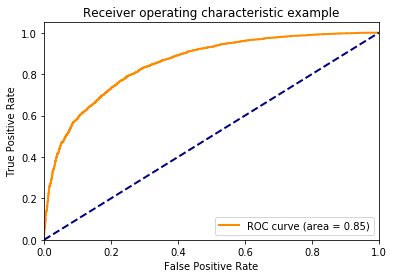

In [64]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right");

In [65]:
gb=clf.best_estimator_

In [66]:
clf.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400}

In [67]:
gb.feature_importances_

array([0.18925916, 0.09811155, 0.08128203, 0.0809817 , 0.12121126,
       0.13748337, 0.02574845, 0.15403841, 0.03254711, 0.04877731,
       0.03055966])

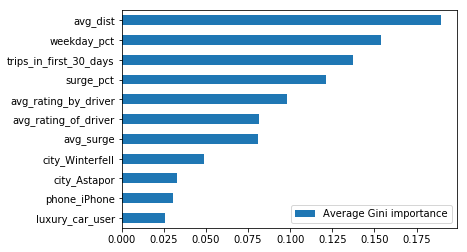

In [68]:
feat_scores = pd.DataFrame({'Average Gini importance' : gb.feature_importances_},
                           index=x.columns)
feat_scores = feat_scores.sort_values(by='Average Gini importance')
feat_scores.plot(kind='barh');

In [69]:
y_pred = gb.predict_proba(x_test)[:,1]>thresholds[2100]
confusion_matrix(y_test, y_pred)

array([[1724, 1281],
       [ 470, 4525]])

# Random Forests